# 迁移学习
- fine tuning:从一个预训练模型开始，改变一些模型的架构，然后继续训练正规模型参数 (训练一整个大模型)
- feature extraction ： 不再改变预训练模型的参数，而是只更新我们改变过的部分模型参数。把CNN当做一个特征提取模型，利用提取出来的特征来做训练任务 (训练最后几层)

## 构建和训练迁移模型的基本步骤
- 初始化预训练模型
- 把最后一层的输出层改成我们想要的分类总数
- 定义一个optimizer来更新参数(用fine tuning的话optimizer要更新整个大模型，feature extraction只更新最后一层)
- 模型训练

In [1]:
import numpy as np
import torchvision
import torch
from torch import nn
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
import time
import os
import copy
print("Torchvision Version: ",torchvision.__version__)

Torchvision Version:  0.8.1


In [2]:
model_name = 'resnet'
num_classes = 2
batch_size = 32
num_epochs = 15
input_size = 224
feature_extract = True # 训练时用fine tuning(False)还是feature extraction(True)

## 读入数据

In [3]:
data_root = os.path.abspath(os.path.join(os.getcwd(),"/data2"))
image_path = os.path.join(data_root,"hymenoptera_data")
assert os.path.exists(image_path),"{} path does not exist".format(image_path)

In [4]:
data_transforms = {
    'train':transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(root=os.path.join(image_path,x),transform=data_transforms[x]) for x in ['train','val']}

dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
        batch_size=batch_size, shuffle=True, num_workers=4) for x in ["train", "val"]}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
img = next(iter(dataloaders_dict['val']))[0]


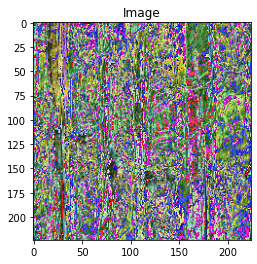

In [6]:
unloader = transforms.ToPILImage() #reconvert into PIL image
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone() 
    image = image.squeeze(0)  # remove batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated 稍作停顿，以便更新绘图
    
    
plt.figure()
imshow(img[28],title='Image')

In [7]:
train_dataset = datasets.ImageFolder(root=os.path.join(image_path,'train'),
                                    transform=transforms.Compose([
                                        transforms.RandomResizedCrop(input_size),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor()
                                    ]))
train_num = len(train_dataset)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

In [8]:
img = next(iter(train_loader))[0]
import matplotlib.pyplot as plt
img.shape

torch.Size([32, 3, 224, 224])

## 定义模型

In [9]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def set_parameter_requires_grad(model, feature_extract):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad=False
            

def initialize_model(model_name,num_classes,feature_extract,use_pretrained=True):
    if model_name == 'resnet':
        model_ft = models.resnet18() # ture拿到一个预训练好的模型 false拿到的随机初始化的未被训练的模型  +pretrained=use_pretrained报错 invalid load key, '<'.
        set_parameter_requires_grad(model_ft,feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 224
    else:
        print('model not implemented')
        return None,None
    return model_ft, input_size
        
    
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [28]:
model1 = models.resnet18()
model1.fc

Linear(in_features=512, out_features=1000, bias=True)

In [11]:
model_ft.fc.weight.requires_grad

True

In [12]:
model_ft.layer1[0].conv1.weight.requires_grad

False

In [23]:
def train_model(model,dataloaders,loss_fn,optimizer,num_epochs=5):
    best_model_weight = copy.deepcopy(model.state_dict())
    best_acc = 0.
    
    for epoch in range(num_epochs):
        for phase in ['train','val']:
            running_loss = 0.
            running_correct = 0.
            val_acc_history = []
            
            if phase=='train':
                model.train()
            else:
                model.eval()
                
            for inputs,labels in dataloaders_dict[phase]:
                inputs, labels = inputs.to(device),labels.to(device)
                
                with torch.autograd.set_grad_enabled(phase == 'train'): 
                    outputs = model(inputs) # bsize *2
                    loss = loss_fn(outputs,labels)
                    
                preds = outputs.argmax(dim=1)
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.item()*inputs.size(0)
                running_correct+=torch.sum(preds.view(-1)==labels.view(-1)).item()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_correct / len(dataloaders[phase].dataset)
            print("Phase {} loss:{}, acc:{}".format(phase,epoch_loss,epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weight = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                
    model.load_state_dict(best_model_weight)
    return model



In [26]:
model_ft = model_ft.to(device)
optimizer = torch.optim.SGD(filter(lambda p:p.requires_grad, model_ft.parameters()), lr=0.001,momentum=0.9) # 拿到所有可更新的参数
loss_fn = nn.CrossEntropyLoss()

_,ohist = train_model(model_ft,dataloaders_dict,loss_fn,optimizer,num_epochs=5)

Phase train loss:0.6854691661772181, acc:0.5368852459016393
Phase val loss:0.675705582098244, acc:0.5816993464052288
Phase train loss:0.6867839527911828, acc:0.5655737704918032
Phase val loss:0.663690027068643, acc:0.6535947712418301
Phase train loss:0.7229986190795898, acc:0.5286885245901639
Phase val loss:0.7061126563284132, acc:0.46405228758169936
Phase train loss:0.6968039508725776, acc:0.5368852459016393
Phase val loss:0.6573362650434955, acc:0.6470588235294118
Phase train loss:0.667203001311568, acc:0.6065573770491803
Phase val loss:0.6796938570496304, acc:0.5490196078431373


TypeError: cannot unpack non-iterable ResNet object

In [25]:
dataloaders_dict['val']